# Analise exploratória de dados

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as sct
import statsmodels.api as sm

In [2]:
# Configurando a pasta dos recursos e de destino
diretorio_raiz = os.getcwd()
diretorio_raiz = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

diretorio_data = os.path.join(diretorio_raiz, 'data')
diretorio_output = os.path.join(diretorio_raiz, 'output')

print(f'diretorio_raiz: {diretorio_raiz}')
print(f'diretorio_data: {diretorio_data}') 
print(f'diretorio_output: {diretorio_output}')

# Adicionando o diretorio raiz no ambiente para possibilitar realizar importações
sys.path.insert(0, diretorio_raiz)

In [3]:
from src.experimentos import Experimentos
from src.utils import Utils

# Instanciando os objetos do projeto
utils = Utils()
experimentos = Experimentos()

In [4]:
# Realizando algumas configuração para o notebook em relação a exibição de linhas e colunas

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set()

In [6]:
# Leitura dos dados
market = pd.read_csv(os.path.join(diretorio_data, 'estaticos_market.csv'), index_col=0)

In [7]:
market.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,dt_situacao,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,fl_optante_simples,qt_art,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,vl_potenc_cons_oleo_gas,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,de_indicador_telefone,fl_simples_irregular,vl_frota,empsetorcensitariofaixarendapopulacao,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,qt_socios_st_suspensa,qt_socios_masculino,qt_socios_feminino,qt_socios_pep,qt_alteracao_socio_total,qt_alteracao_socio_90d,qt_alteracao_socio_180d,qt_alteracao_socio_365d,qt_socios_pj_ativos,qt_socios_pj_nulos,qt_socios_pj_baixados,qt_socios_pj_suspensos,qt_socios_pj_inaptos,vl_idade_media_socios_pj,vl_idade_maxima_socios_pj,vl_idade_minima_socios_pj,qt_coligados,qt_socios_coligados,qt_coligados_matriz,qt_coligados_ativo,qt_coligados_baixada,qt_coligados_inapta,qt_coligados_suspensa,qt_coligados_nula,idade_media_coligadas,idade_maxima_coligadas,idade_minima_coligadas,coligada_mais_nova_ativa,coligada_mais_antiga_ativa,idade_media_coligadas_ativas,coligada_mais_nova_baixada,coligada_mais_antiga_baixada,idade_media_coligadas_baixadas,qt_coligados_sa,qt_coligados_me,qt_coligados_mei,qt_coligados_ltda,qt_coligados_epp,qt_coligados_norte,qt_coligados_sul,qt_coligados_nordeste,qt_coligados_centro,qt_coligados_sudeste,qt_coligados_exterior,qt_ufs_coligados,qt_regioes_coligados,qt_ramos_coligados,qt_coligados_industria,qt_coligados_agropecuaria,qt_coligados_comercio,qt_coligados_serviço,qt_coligados_ccivil,qt_funcionarios_coligados,qt_funcionarios_coligados_gp,media_funcionarios_coligados_gp,max_funcionarios_coligados_gp,min_funcionarios_coligados_gp,vl_folha_coligados,media_vl_folha_coligados,max_vl_folha_coligados,min_vl_folha_coligados,vl_folha_coligados_gp,media_vl_folha_coligados_gp,max_vl_folha_coligados_gp,min_vl_folha_coligados_gp,faturamento_est_coligados,media_faturamento_est_coligados,max_faturamento_est_coligados,min_faturamento_est_coligados,faturamento_est_coligados_gp,media_faturamento_est_coligados_gp,max_faturamento_est_coligados_gp,min_faturamento_est_coligados_gp,total_filiais_coligados,media_filiais_coligados,max_filiais_coligados,min_filiais_coligados,qt_coligados_atividade_alto,qt_coligados_atividade_medio,qt_coligados_atividade_baixo,qt_coligados_atividade_mt_baixo,qt_coligados_atividade_inativo,qt_coligadas,sum_faturamento_estimado_coligadas,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_ex_funcionarios,qt_funcionarios_grupo,percent_func_genero_masc,percent_func_genero_fem,idade_ate_18,idade_de_19_a_23,idade_de_24_a_28,idade_de_29_a_33,idade_de_34_a_38,idade_de_39_a_43,idade_de_44_a_48,idade_de_49_a_53,idade_de_54_a_58,idade_acima_de_58,grau_instrucao_macro_analfabeto,grau_instrucao_macro_escolaridade_fundamental,grau_instrucao_macro_escolaridade_media,grau_instrucao_macro_escolaridade_superior,grau_instrucao_macro_desconhecido,total,meses_ultima_contratacaco,qt_admitidos_12meses,qt_desligados_12meses,qt_desligados,qt_admitidos,media_meses_servicos_all,max_meses_servicos_all,min_meses_servicos_all,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,False,Fals

In [8]:
market_info = utils.descrever_dataframe(market)
market_info.tipo.value_counts()

float64    144
object      27
bool         9
int64        1
Name: tipo, dtype: int64

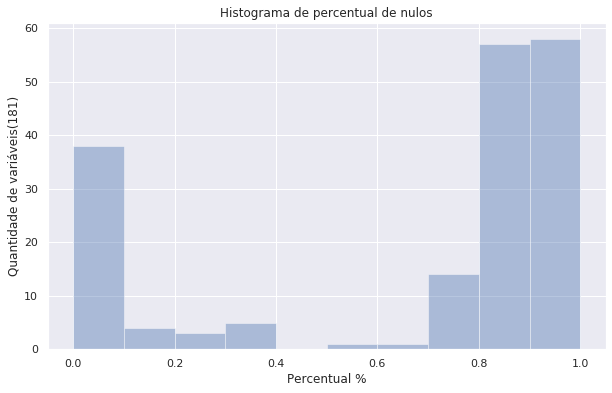

In [9]:
# Exibindo grafico pra observar as concentrações dos percentuais faltantes dos dados
plt.figure(figsize=(10, 6))
plt.title('Histograma de percentual de nulos')
ax = sns.distplot(market_info['porcentagem_nulos'], bins=10, kde=False)

plt.xlabel('Percentual %')
plt.ylabel(f'Quantidade de variáveis({market.shape[1]})')
plt.show()

Ao realizar a visualização dos dados em relação ao percentual faltante, pôde-se observar que a maior parte das variáveis está com 70% ou mais, sendo assim há uma grande ausencia de informações.

## Tratamento de dados faltantes

O tratamento dos dados faltantes se tornou uma etapa muito importante no pré-processamento justamente pelo grande número de variáveis com percentuais elevados, portanto foi traçado uma estratégia para tratar de tal fato que se dá na forma dos seguintes passos:
* [Verificação das variáveis com 100%](#Investigação:-Variáveis-com-100%-faltante)
* [Investigação das variáveis com 70% ou mais](#Investigação:-Percentual-faltante-igual-ou-superior-à-70%)
* [Analise das variáveis com menos de 70%](#Investigação:-Variáveis-percentual-inferior-à-70%-faltante)

As variáveis com 100% de nulos serão verificadas para compreender a natureza dessas observações para concluir que ao deletar não estaria perdendo informações relevantes como por exemplo relação com alguma outra. Posteriomente serão as variáveis com percentual nulo igual ou superior a 70% para ter alguma conclusão sobre o aproveitamente das próprias, posteriormente as demais.

### Investigação: Variáveis com 100% faltante

Apesar de não conter informações sobre os dados, pois não contém nenhum valor preenchido vou analisa-las para verificar se não contém nenhuma relação com outra ou até mesmo compreender do que se tratam.

In [10]:
# Extraindo os dados com todos os dados considerados faltantes
market_variaveis_faltante = market_info[market_info.porcentagem_nulos >= 1.0].coluna.values
market_faltante = market[market_variaveis_faltante].copy()

market_faltante.dtypes.value_counts()

float64    5
dtype: int64

In [11]:
market_faltante.describe()

,qt_alteracao_socio_total,qt_alteracao_socio_90d,qt_alteracao_socio_180d,qt_alteracao_socio_365d,grau_instrucao_macro_desconhecido
count,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


In [12]:
for variavel in market_variaveis_faltante:
    print(utils.descrever_variavel(variavel))

('qt_alteracao_socio_total', 'integer value, quantity of changes in the QSA')
('qt_alteracao_socio_90d', 'integer value, quantity of changes in the QSA in the last 90 days')
('qt_alteracao_socio_180d', 'integer value, quantity of changes in the QSA in the last 180 days')
('qt_alteracao_socio_365d', 'integer value, quantity of changes in the QSA in the last 365 days')
('grau_instrucao_macro_desconhecido', 'integer value, same as grau_instrucao_desconhecido')


Investigando do que se trata as variáveis `qt_alteracao_socio_total, qt_alteracao_socio_90d, qt_alteracao_socio_180d, qt_alteracao_socio_365d` descobri que se originam de um serviço de Consulta ao Quadro de Sócios e Administradores (QSA) que permite descobrir sócios de uma empresa [Fonte](https://blog.brasilconsultas.com.br/como-descobrir-socios-de-uma-empresa/).

Agora para a variável `grau_instrucao_macro_desconhecido` está descrito que equivale a `grau_instrucao_desconhecido` que nem existe nos dados, portanto, decide-se remover as variaveis com todos os dados faltantes.

In [13]:
# Armazenando as colunas que irão ser deletadas
market_info['deletar'] = False
market_info.loc[market_info.porcentagem_nulos >= 1.0, 'deletar'] = True

### Investigação: Percentual faltante igual ou superior à 70%

In [14]:
# Extraindo os dados com todos os dados considerados faltantes
market_variaveis_faltante = market_info[(market_info.porcentagem_nulos >= 0.7) 
                                        & (market_info.porcentagem_nulos < 1.0)].coluna.values

market_faltante = market[market_variaveis_faltante].copy()

market_faltante.dtypes.value_counts()

float64    123
object       1
dtype: int64

In [15]:
market_faltante.describe()

,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,qt_art,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,vl_potenc_cons_oleo_gas,vl_frota,qt_socios_st_suspensa,qt_socios_pep,qt_socios_pj_ativos,qt_socios_pj_nulos,qt_socios_pj_baixados,qt_socios_pj_suspensos,qt_socios_pj_inaptos,vl_idade_media_socios_pj,vl_idade_maxima_socios_pj,vl_idade_minima_socios_pj,qt_coligados,qt_socios_coligados,qt_coligados_matriz,qt_coligados_ativo,qt_coligados_baixada,qt_coligados_inapta,qt_coligados_suspensa,qt_coligados_nula,idade_media_coligadas,idade_maxima_coligadas,idade_minima_coligadas,coligada_mais_nova_ativa,coligada_mais_antiga_ativa,idade_media_coligadas_ativas,coligada_mais_nova_baixada,coligada_mais_antiga_baixada,idade_media_coligadas_baixadas,qt_coligados_sa,qt_coligados_me,qt_coligados_mei,qt_coligados_ltda,qt_coligados_epp,qt_coligados_norte,qt_coligados_sul,qt_coligados_nordeste,qt_coligados_centro,qt_coligados_sudeste,qt_coligados_exterior,qt_ufs_coligados,qt_regioes_coligados,qt_ramos_coligados,qt_coligados_industria,qt_coligados_agropecuaria,qt_coligados_comercio,qt_coligados_serviço,qt_coligados_ccivil,qt_funcionarios_coligados,qt_funcionarios_coligados_gp,media_funcionarios_coligados_gp,max_funcionarios_coligados_gp,min_funcionarios_coligados_gp,vl_folha_coligados,media_vl_folha_coligados,max_vl_folha_coligados,min_vl_folha_coligados,vl_folha_coligados_gp,media_vl_folha_coligados_gp,max_vl_folha_coligados_gp,min_vl_folha_coligados_gp,faturamento_est_coligados,media_faturamento_est_coligados,max_faturamento_est_coligados,min_faturamento_est_coligados,faturamento_est_coligados_gp,media_faturamento_est_coligados_gp,max_faturamento_est_coligados_gp,min_faturamento_est_coligados_gp,total_filiais_coligados,media_filiais_coligados,max_filiais_coligados,min_filiais_coligados,qt_coligados_atividade_alto,qt_coligados_atividade_medio,qt_coligados_atividade_baixo,qt_coligados_atividade_mt_baixo,qt_coligados_atividade_inativo,qt_coligadas,sum_faturamento_estimado_coligadas,qt_ex_funcionarios,qt_funcionarios_grupo,percent_func_genero_masc,percent_func_genero_fem,idade_ate_18,idade_de_19_a_23,idade_de_24_a_28,idade_de_29_a_33,idade_de_34_a_38,idade_de_39_a_43,idade_de_44_a_48,idade_de_49_a_53,idade_de_54_a_58,idade_acima_de_58,grau_instrucao_macro_analfabeto,grau_instrucao_macro_escolaridade_fundamental,grau_instrucao_macro_escolaridade_media,grau_instrucao_macro_escolaridade_superior,total,meses_ultima_contratacaco,qt_admitidos_12meses,qt_desligados_12meses,qt_desligados,qt_admitidos,media_meses_servicos_all,max_meses_servicos_all,min_meses_servicos_all,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade
count,280.000000,176.000000,30684.000000,30684.000000,6590.000000,1760.000000,336.000000,3683.000000,2.419000e+04,3251.000000,6743.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,4544.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.0,65391.000000,65391.000000,65391.000000,65147.000000,65147.000000,65147.000000,136.000000,136.000000,136.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,65391.000000,42303.000000,4.230300e+04,4.230300e+04,4.230300e+04,4.230300e+04,3.631400e+04,3.631400e+04,3.631400e+04,3.631400e+04,3.653700e+04,3.653700e+04,3.653700e+04,3.653700e+04,6.452300e+04,6.452300e+04,6.452300e+04,6.452300e+04,6.452300e+04,6.452300e+04,6.452300e+04,6.452300e+04,20400.000000,20400.000000,20400.000000,20400.000000,65391.0,65391.0,65391.0,65391.0,65391.0,50231.000000,4.954400e+04,115254.000000,1.152630e+05,75942.000000,75942.000000,2906.000000,25890.000000,38895.000000,40143.000

As variáveis `qt_coligados_nula`, `qt_coligados_atividade_inativo`, `qt_coligados_atividade_alto`, `qt_coligados_atividade_medio`, `qt_coligados_atividade_baixo`, `qt_coligados_atividade_mt_baixo`, `qt_coligados_atividade_inativo` estão com minimo e máximo zerado, pode ser variáveis que podem ser removidas.

In [16]:
variaveis_faltantes_observar = ['qt_coligados_nula', 'qt_coligados_atividade_inativo', 
                                'qt_coligados_atividade_alto', 'qt_coligados_atividade_medio', 
                                'qt_coligados_atividade_baixo','qt_coligados_atividade_mt_baixo', 
                                'qt_coligados_atividade_inativo']

for variavel in variaveis_faltantes_observar:
    print(utils.descrever_variavel(variavel))

('qt_coligados_nula', 'integer value, quantity of connected companies that are considered as nule companies according to the IRS')
('qt_coligados_atividade_inativo', "integer value, quantity of connected companies with estimated activity level classifier equal to 'INATIVO'")
('qt_coligados_atividade_alto', "integer value, quantity of connected companies with estimated activity level classifier equal to 'ALTO'")
('qt_coligados_atividade_medio', "integer value, quantity of connected companies with estimated activity level classsifier equal to 'Medio'")
('qt_coligados_atividade_baixo', "integer value, quantity of connected companies with estimated activity level classifier equal to 'Baixo'")
('qt_coligados_atividade_mt_baixo', "integer value, quantity of connected companies with estimate activity level classifier equal to 'Muito Baixo'")
('qt_coligados_atividade_inativo', "integer value, quantity of connected companies with estimated activity level classifier equal to 'INATIVO'")


In [17]:
market_info.loc[market_info.coluna.isin(variaveis_faltantes_observar), 'deletar'] = True

Analisando os dados descritos do do dicionario a variável `qt_coligados_nula` está ligado a agência tributaria americana [Fonte](https://pt.wikipedia.org/wiki/Internal_Revenue_Service) e outras trata-se e conexão com outras empresas de acordo com a classificação de frequência.

In [18]:
for variavel in market_info[market_info.deletar == False].coluna.values:
     print(utils.descrever_variavel(variavel))

('id', 'Variável não encontrada no dicionário')
('fl_matriz', 'boolean value, true if the CNPJ corresponds to the "matriz".')
('de_natureza_juridica', 'character, juridic nature of the company.')
('sg_uf', 'character, initials of the name of the state of the company.')
('natureza_juridica_macro', 'a macro legal category for "natureza jurídica".')
('de_ramo', 'description of a macro activity category/branch based on the CNAE code.')
('setor', 'character, economic sector of the company (Industry, Services, Agrobusiness, Etc.)')
('idade_empresa_anos', 'numeric value, age of the company.')
('idade_emp_cat', 'character, age of the company by ranges')
('fl_me', "boolean value, true if the company has the term 'ME' in the end of its legal name.")
('fl_sa', "boolean value, true if the company has the term 'SA' in the end of its legal name.")
('fl_epp', "boolean value, true if the company has the term 'EPP' in the end of its legal name.")
('fl_mei', "boolean value, true if the company has the t

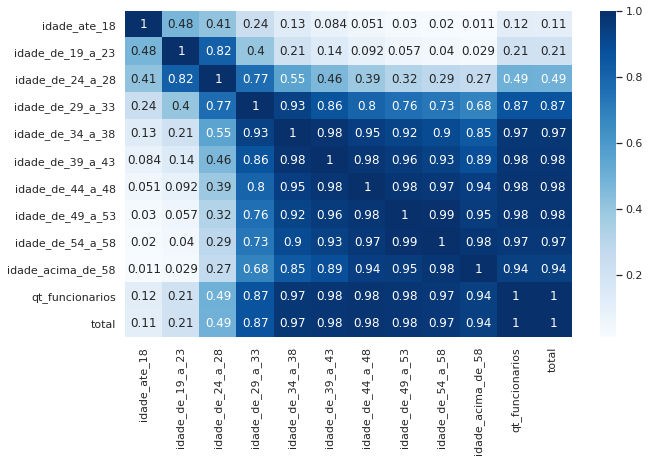

In [19]:
variaveis_faltantes_observar = ['idade_ate_18', 'idade_de_19_a_23', 'idade_de_24_a_28', 'idade_de_29_a_33', 
                                'idade_de_34_a_38', 'idade_de_39_a_43', 'idade_de_44_a_48', 'idade_de_49_a_53', 
                                'idade_de_54_a_58', 'idade_acima_de_58', 'qt_funcionarios', 'total']
                                
plt.figure(figsize=(10, 6))
ax = sns.heatmap(market_faltante[variaveis_faltantes_observar].fillna(0).corr(), cmap='Blues', annot=True)
plt.show()

In [20]:
np.sum(1 - market_info[market_info.coluna.isin(['idade_ate_18', 'idade_de_19_a_23', 'idade_de_24_a_28', 'idade_de_29_a_33', 
                                'idade_de_34_a_38', 'idade_de_39_a_43', 'idade_de_44_a_48', 'idade_de_49_a_53', 
                                'idade_de_54_a_58', 'idade_acima_de_58'])].porcentagem_nulos)

0.5262817490017262

valores = []
for i, valor in market_faltante.iterrows():
    if np.isnan(valor.qt_funcionarios) and np.isnan(valor.total):
        valores.append(np.nan)
    elif np.isnan(valor.qt_funcionarios) and np.notnan(valor.total):
        valores.append(valor.total)
    else:
        valores.append(valor.qt_funcionarios)

market_faltante['qt_funcionarios_total'] = valores
msno.matrix(market_faltante[['qt_funcionarios', 'total','qt_funcionarios_total']])
plt.show()

In [21]:
# Removendo as colunas que tem 100% de dados faltantes
market_info.loc[(market_info.porcentagem_nulos >= 0.7)
                & (market_info.porcentagem_nulos < 1.0), 'deletar'] = True

market_info.deletar.value_counts()

True     129
False     52
Name: deletar, dtype: int64

### Investigação: Variáveis percentual inferior à 70% faltante

In [22]:
# Extraindo os dados com todos os dados considerados faltantes
market_variaveis_faltante = market_info[market_info.porcentagem_nulos < 0.7].coluna.values
market_faltante = market[market_variaveis_faltante].copy()
market_faltante.dtypes.value_counts()

object     26
float64    16
bool        9
int64       1
dtype: int64

msno.matrix(market_faltante)
plt.show()

In [23]:
print(f'Variáveis sem ausência de dados: {market_info[market_info.porcentagem_nulos == 0].coluna.values}')

Variáveis sem ausência de dados: ['id' 'fl_matriz' 'de_natureza_juridica' 'sg_uf' 'natureza_juridica_macro'
 'de_ramo' 'idade_empresa_anos' 'idade_emp_cat' 'fl_me' 'fl_sa' 'fl_epp'
 'fl_mei' 'fl_ltda' 'fl_st_especial' 'fl_email' 'fl_telefone' 'fl_rm'
 'qt_filiais']


In [24]:
market_faltante.describe()

,idade_empresa_anos,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,empsetorcensitariofaixarendapopulacao,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,qt_socios_masculino,qt_socios_feminino,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
count,462298.000000,460371.000000,460371.000000,417022.000000,318469.000000,347207.000000,347207.000000,347207.000000,310696.000000,310696.000000,310696.000000,307381.000000,195115.000000,145029.000000,4.347850e+05,4.347850e+05,462298.000000
mean,9.948677,3.591801,48.699177,25.007247,1308.005725,1.496326,1.476681,0.019645,42.816452,44.344131,41.355225,1.396082,1.353925,1.107117,8.020911e+05,3.367205e+08,28.737044
std,9.615664,72.600352,1206.696804,9.679799,1161.889222,3.276626,3.258079,0.195166,12.626447,13.930385,12.514921,2.578793,2.848980,0.840194,3.099979e+07,7.114614e+09,468.626094
min,0.016438,0.000000,0.000000,0.000000,100.000000,1.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,1.000000,1.000000,1.000000,0.000000e+00,4.104703e+04,0.000000
25%,2.756164,0.000000,0.000000,22.000000,673.230000,1.000000,1.000000,0.000000,33.000000,34.000000,32.000000,1.000000,1.000000,1.000000,1.648512e+05,1.854576e+05,0.000000
50%,6.704110,0.000000,0.000000,23.000000,946.680000,1.000000,1.000000,0.000000,42.000000,43.000000,40.000000,1.000000,1.000000,1.000000,2.100000e+05,2.100000e+05,0.000000
75%,14.465753,0.000000,0.000000,25.000000,1518.080000,2.000000,2.000000,0.000000,51.000000,54.000000,50.000000,1.000000,1.000000,1.000000,2.100000e+05,2.100000e+05,0.000000
max,106.432877,9782.000000,122090.000000,66.000000,75093.840000,246.000000,246.000000,13.000000,127.000000,127.000000,127.000000,179.000000,84.000000,140.000000,1.454662e+10,2.227618e+11,9647.000000


Realizando uma investigação preliminar nos dados observei que as variáveis `idade_media_socios`,  `idade_maxima_socios`,  `idade_minima_socios` estão com anomalias, chego a essa conclusão devido **idade minima é de -2 e máxima de 127 anos** para ambas.

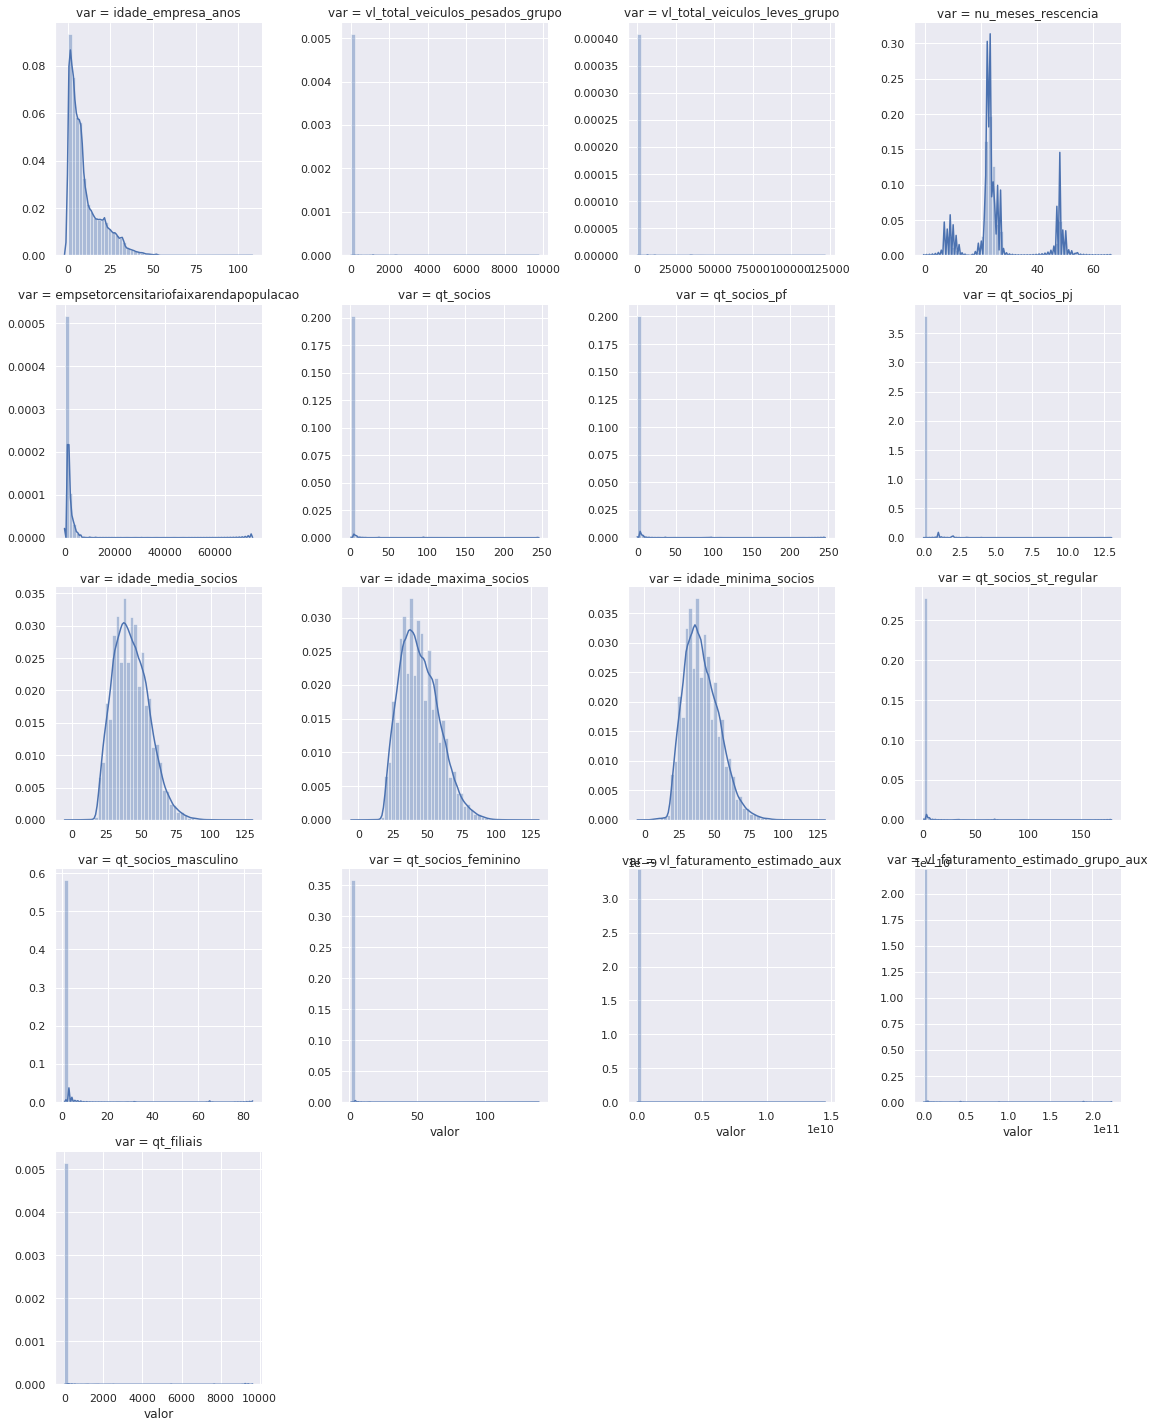

In [25]:
# Exibir histograma de todas variaveis numericas
market_variaveis_analise = market_info[(market_info.coluna.isin(market_variaveis_faltante))
                                       & ((market_info.tipo == 'float64') 
                                       | (market_info.tipo == 'int'))].coluna.values

experimentos.criar_histogramas(market_faltante, market_variaveis_analise, col_wrap=4)
plt.show()

A `idade_empresa_anos` aparenta ser uma [lei de potência](https://en.wikipedia.org/wiki/Power_law) que representa relacionamento entre duas quantidades, porém, se trata de uma data independente. [ref. google-machine-learning](https://developers.google.com/machine-learning/clustering/prepare-data)

As variáveis `idade_media_socios`,  `idade_maxima_socios`,  `idade_minima_socios` mencionadas acima com outliers aparentam ser distribuições normais, mas é preciso realizar testes. A distribuição `nu_meses_recencia` contém alguns picos de frequência e as demais variáveis possui sua frequência proximas ao valor zero.

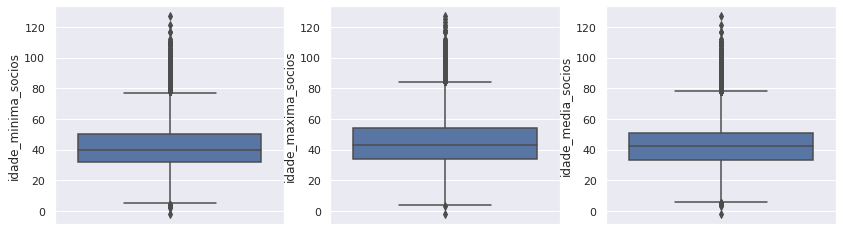

In [26]:
# Definindo as varáveis para analise
market_variaveis_analise = ['idade_minima_socios', 'idade_maxima_socios', 'idade_media_socios']
experimentos.criar_diagrama_caixa(market_faltante, market_variaveis_analise)
plt.show()

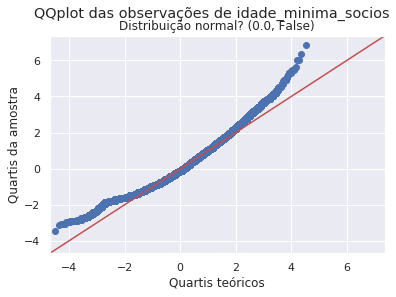

In [27]:
sm.qqplot(market_faltante['idade_minima_socios'].dropna(), fit=True, line="45")

plt.xlabel('Quartis teóricos')
plt.ylabel('Quartis da amostra')
plt.suptitle('QQplot das observações de idade_minima_socios')
plt.title(f'Distribuição normal? {experimentos.verificar_distribuicao_normal(market_faltante.idade_minima_socios.dropna(), 0.05)}')
plt.show()

In [28]:
# Tratamento de anonalias
outliers = experimentos.deteccao_anomalia(market_faltante['idade_minima_socios'])
print(f'idade_minima_socios: [min, max] = [{outliers[0]} , {outliers[1]}]')
market_faltante.loc[outliers[2], 'idade_minima_socios'] = np.nan
market.loc[outliers[2], 'idade_minima_socios'] = np.nan


outliers = experimentos.deteccao_anomalia(market_faltante['idade_maxima_socios'])
print(f'idade_maxima_socios: [min, max] = [{outliers[0]} , {outliers[1]}]')
market_faltante.loc[outliers[2], 'idade_maxima_socios'] = np.nan
market.loc[outliers[2], 'idade_maxima_socios'] = np.nan


outliers = experimentos.deteccao_anomalia(market_faltante['idade_media_socios'])
print(f'idade_media_socios: [min, max] = [{outliers[0]} , {outliers[1]}]')
market_faltante.loc[outliers[2], 'idade_media_socios'] = np.nan
market.loc[outliers[2], 'idade_media_socios'] = np.nan

idade_minima_socios: [min, max] = [5.0 , 77.0]
idade_maxima_socios: [min, max] = [4.0 , 84.0]
idade_media_socios: [min, max] = [6.0 , 78.0]


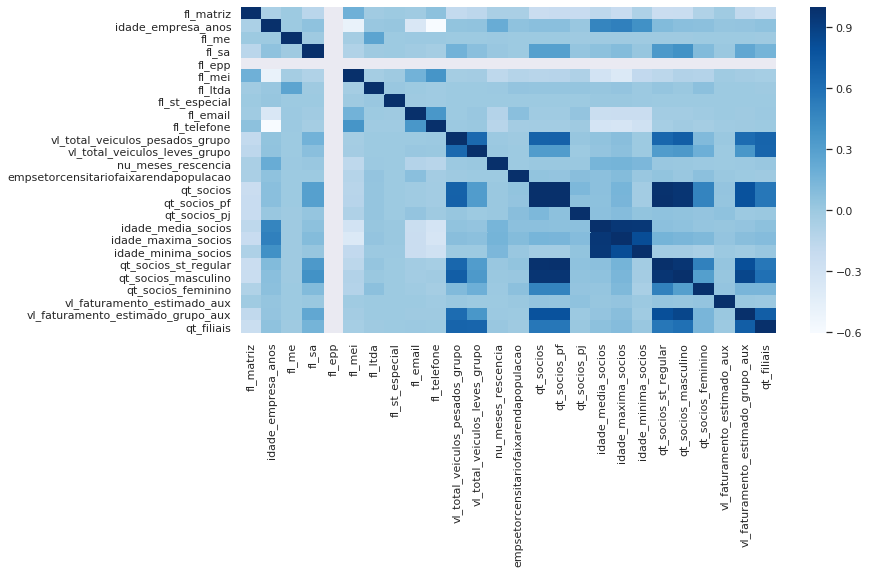

In [35]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(market[market_info[market_info.deletar==False].coluna.values].corr(), 
                 cmap='Blues')
plt.show()

In [34]:
# Verificando porque a fl_epp não tem valor de correlação

market.fl_epp.value_counts()

False    462298
Name: fl_epp, dtype: int64

A variável `fl_epp` será removida devido ao fato de só conter valores falsos

In [ ]:
market_info.loc[market_info.coluna == 'fl_epp', 'deletar'] = True

valores = []
for i, valor in market.iterrows():
    if np.isnan(valor.qt_socios_masculino) and np.isnan(valor.qt_socios_feminino):
        valores.append(np.nan)
    elif np.isnan(valor.qt_socios_masculino) and not np.isnan(valor.qt_socios_feminino):
        valores.append(valor.qt_socios_feminino)
    else:
        valores.append(valor.qt_socios_masculino)

market['qt_socios_ambos'] = valores
msno.matrix(market[['qt_socios_feminino', 'qt_socios_masculino','qt_socios_ambos']])
plt.show()

In [30]:
market_faltante = market[['qt_socios_masculino', 'qt_socios_feminino']].fillna(0)
market_faltante['ambos'] = market_faltante.qt_socios_masculino + market_faltante.qt_socios_feminino
market_faltante['qt_socios'] = market.qt_socios
market_faltante['dif'] = market_faltante['qt_socios']-market_faltante['ambos']
#market_faltante.dropna(subset=['qt_socios'], axis=0, inplace=True)

market_faltante[(market_faltante.ambos != market_faltante.qt_socios)
                & (~np.isnan(market_faltante.qt_socios))].dif.value_counts()

1.0     57428
2.0      8272
3.0      1704
4.0       556
28.0      266
5.0       255
6.0       230
8.0        72
7.0        56
9.0        40
13.0       33
10.0       29
11.0       19
16.0       19
12.0        5
17.0        5
41.0        2
15.0        2
19.0        2
14.0        2
34.0        1
40.0        1
18.0        1
22.0        1
67.0        1
58.0        1
33.0        1
72.0        1
25.0        1
31.0        1
63.0        1
43.0        1
Name: dif, dtype: int64

In [33]:
# Removendo os dados após investigação

market.drop(labels=market_info[market_info.deletar == True].coluna.values, axis=1, inplace=True)

market.to_pickle(os.path.join(diretorio_output, 'market_preprocessado.zip'))